In [ ]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
from datetime import datetime

def experiment_version_frequency(experiment_name, start_time, end_time, tracking_uri="http://localhost/mlflow-service"):
    """
    Prints experiment id, run count, and average frequency of model versions for a given experiment name and time range.
    start_time and end_time should be in 'YYYY-MM-DD HH:MM:SS' format.
    Average frequency is now calculated per second.
    """
    client = MlflowClient(tracking_uri=tracking_uri)
    exp = client.get_experiment_by_name(experiment_name)
    if exp is None:
        print(f"Experiment '{experiment_name}' not found.")
        return
    runs = client.search_runs([exp.experiment_id])
    # Convert start/end time to timestamps
    start_ts = int(pd.Timestamp(start_time).timestamp() * 1000)
    end_ts = int(pd.Timestamp(end_time).timestamp() * 1000)
    filtered_runs = [run for run in runs if start_ts <= run.info.start_time <= end_ts]
    print(f"Experiment ID: {exp.experiment_id}")
    print(f"Run count: {len(filtered_runs)}")
    if filtered_runs:
        times = [run.info.start_time for run in filtered_runs]
        times.sort()
        # Calculate average frequency (runs per second)
        duration = (max(times) - min(times)) / 1000  # seconds
        avg_freq = len(filtered_runs) / duration if duration > 0 else len(filtered_runs)
        print(f"Average frequency: {avg_freq:.6f} runs per second")
        print("Run IDs and start times:")
        for run in filtered_runs:
            dt = datetime.fromtimestamp(run.info.start_time / 1000)
            print(f"Run ID: {run.info.run_id}, Start Time: {dt}")
    else:
        print("No runs found in the specified time range.")

# Example usage:
experiment_version_frequency("AGR_a-HT-old-2000", "2025-07-19 00:00:00", "2025-07-19 23:59:59")


In [4]:
# Get C:\Users\muhammad.aulia\large-scale-online-learning\Datasets\real_usage\AGR_a_first_train.csv
dataset_directory = "C:\\Users\\muhammad.aulia\\large-scale-online-learning\\Datasets\\real_usage\\"
agr_g_real_test_dataset = "AGR_g_real_test.csv"

# Count how many rows are in the dataset
import os

dataset_path = os.path.join(dataset_directory, agr_g_real_test_dataset)

# Count the number of rows in the dataset
with open(dataset_path, 'r') as f:
    num_rows = sum(1 for line in f) - 1  # Subtract 1 for header row
    print(f"Number of rows in {agr_g_real_test_dataset}: {num_rows}")


Number of rows in AGR_g_real_test.csv: 495000


In [5]:
# Get C:\Users\muhammad.aulia\large-scale-online-learning\MLOps-Architecture\Serialization_Datasets\experiment-results\AGR_g-HT-old-1000-2000VU\inference-results
import glob
import tarfile


inference_results_directory = "C:\\Users\\muhammad.aulia\\large-scale-online-learning\\MLOps-Architecture\\Serialization_Datasets\\experiment-results\\AGR_g-HT-old-1000-2000VU\\inference-results"

# Read every load_model_*.csv.tar.gz and extract them

for tar_path in glob.glob(os.path.join(inference_results_directory, "load_model_*.csv.tar.gz")):
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=inference_results_directory)


C:\Users\muhammad.aulia\AppData\Local\Temp\ipykernel_11228\1553920003.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=inference_results_directory)


In [ ]:
experiments = ["AGR_g-HT-old-1000-2000VU", "AGR_g-HT-old-1000-10000VU"]
for experiment in experiments:
    inference_results_directory = f"C:\\Users\\muhammad.aulia\\large-scale-online-learning\\MLOps-Architecture\\Serialization_Datasets\\experiment-results\\{experiment}\\inference-results"

    for tar_path in glob.glob(os.path.join(inference_results_directory, "load_model_*.csv.tar.gz")):
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=inference_results_directory)

    mlflow_results_directory = f"C:\\Users\\muhammad.aulia\\large-scale-online-learning\\MLOps-Architecture\\Serialization_Datasets\\experiment-results\\{experiment}\\mlflow-results"

    for tar_path in glob.glob(os.path.join(mlflow_results_directory, "*.tar.gz")):
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=mlflow_results_directory)

    # Get the number of rows in the dataset in MLOps-Architecture/Serialization_Datasets/experiment-results/AGR_g-HT-old-1000-2000VU/inference-results/app
    app_dataset_path = os.path.join(inference_results_directory, "app")

    # Get every csv files from app_dataset_path
    app_csv_files = glob.glob(os.path.join(app_dataset_path, "*.csv"))
    print(f"Experiment: {experiment}")
    for app_csv_file in app_csv_files:
        with open(app_csv_file, 'r') as f_app:
            filename = os.path.basename(app_csv_file)
            num_rows_app = sum(1 for line in f_app) - 1  # Subtract 1 for header row
            print(f"Number of rows in app dataset {filename}: {num_rows_app}")
    print("---------------")

In [113]:
# Read mlflow sqlite DB and align with load-test timestamps (3 minutes before/after)
import sqlite3
import os
import pandas as pd
import time
import datetime
from datetime import timedelta

experiment_name = "AGR_g-HT-old-1000-2000VU"

# Paths
mlflow_db_path = fr"C:\Users\muhammad.aulia\large-scale-online-learning\MLOps-Architecture\Serialization_Datasets\experiment-results\{experiment_name}\mlflow-results\mlartifacts\mlflow.db"
model_upload_csv_path = fr"C:\Users\muhammad.aulia\large-scale-online-learning\MLOps-Architecture\Serialization_Datasets\experiment-results\{experiment_name}\update-results\app\model_upload_latency.csv"
load_test_csv_path = fr"C:\Users\muhammad.aulia\large-scale-online-learning\MLOps-Architecture\Serialization_Datasets\experiment-results\{experiment_name}\load-test-results\result_testing_stats_history.csv"

# Load dataframes
conn = sqlite3.connect(mlflow_db_path)
cursor = conn.cursor()
model_upload_latency_df = pd.read_csv(model_upload_csv_path)
# Ensure columns are named predictably
if len(model_upload_latency_df.columns) >= 3:
    model_upload_latency_df.columns = ['experiment', 'start_time', 'end_time']

load_test_results_df = pd.read_csv(load_test_csv_path)
# Convert the load-test Timestamp column (seconds) to pandas datetime
if 'Timestamp' not in load_test_results_df.columns:
    raise KeyError(f'Expected "Timestamp" column in {load_test_csv_path}')
# Convert the load-test Timestamp column (seconds) to pandas datetime with Asia/Jakarta timezone
timestamps = load_test_results_df['Timestamp']
first_ts = timestamps.min()
last_ts = timestamps.max()
# Convert to pandas Timestamp (assume UTC, or specify tz if needed)
first_ts_dt = pd.to_datetime(first_ts, unit='s')
last_ts_dt = pd.to_datetime(last_ts, unit='s')
# Build 3-minute window before/after
window_start = first_ts_dt - pd.Timedelta(minutes=3)
window_end = last_ts_dt + pd.Timedelta(minutes=3)
# Milliseconds for comparison with mlflow DB (which stores ms since epoch)
window_start_ms = int(window_start.timestamp() * 1000)
window_end_ms = int(window_end.timestamp() * 1000)

# Query mlflow runs whose start_time lies within the window
query = 'SELECT run_uuid, start_time, end_time FROM runs WHERE start_time BETWEEN ? AND ? ORDER BY start_time ASC;'
cursor.execute(query, (window_start_ms, window_end_ms))
runs = cursor.fetchall()

# Helper to format ms timestamps
def fmt_ms(ms):
    if ms is None or (isinstance(ms, float) and pd.isna(ms)):
        return 'N/A'
    try:
        return datetime.datetime.fromtimestamp(int(ms) / 1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
    except Exception:
        return str(ms)

# Pretty printed summary
print('===== Load test window vs MLflow runs =====')
print(f'Experiment: {experiment_name}')
print('')
# Convert timestamps to Asia/Jakarta timezone for display
asia_jakarta = 'Asia/Jakarta'
first_ts_dt_jkt = first_ts_dt.tz_localize('UTC').tz_convert(asia_jakarta)
last_ts_dt_jkt = last_ts_dt.tz_localize('UTC').tz_convert(asia_jakarta)
window_start_jkt = window_start.tz_localize('UTC').tz_convert(asia_jakarta)
window_end_jkt = window_end.tz_localize('UTC').tz_convert(asia_jakarta)

print('Load-test first timestamp :', first_ts_dt_jkt.strftime('%Y-%m-%d %H:%M:%S %Z'))
print('Load-test last  timestamp :', last_ts_dt_jkt.strftime('%Y-%m-%d %H:%M:%S %Z'))
print(f'Window start (first - 3 min): {window_start_jkt.strftime("%Y-%m-%d %H:%M:%S %Z")}')
print(f'Window end   (last  + 3 min): {window_end_jkt.strftime("%Y-%m-%d %H:%M:%S %Z")}')
print('')
# Show matching mlflow runs
if not runs:
    print(f'No MLflow runs found with start_time between {fmt_ms(window_start_ms)} and {fmt_ms(window_end_ms)}')
else:
    print(f'Found {len(runs)} MLflow run(s) in window:')
    for idx, (run_uuid, start_ms, end_ms) in enumerate(runs, start=1):
        start_h = fmt_ms(start_ms)
        end_h = fmt_ms(end_ms)
        duration_s = 'N/A'
        try:
            if start_ms and end_ms:
                duration_s = f'{(int(end_ms) - int(start_ms)) / 1000:.3f} s'
        except Exception:
            pass
        print(f'  [{idx}] run_uuid: {run_uuid}')
        print(f'       start_time: {start_h} | end_time: {end_h} | duration: {duration_s}')

# Show model upload events that fall in the same window (if available)
if 'start_time' in model_upload_latency_df.columns:
    mu = model_upload_latency_df[(model_upload_latency_df['start_time'] >= window_start_ms) & (model_upload_latency_df['start_time'] <= window_end_ms)]
    print('')
    if mu.empty:
        print('No model upload events found inside the window.')
    else:
        print(f'Found {len(mu)} model upload event(s) in window:')
        for i, row in mu.reset_index(drop=True).iterrows():
            s = fmt_ms(row['start_time'])
            e = fmt_ms(row['end_time'])
            print(f'  - [{i+1}] experiment: {row.get(experiment, ) } | start: {s} | end: {e}')

print('===========================================')

# Close DB connection
conn.close()

===== Load test window vs MLflow runs =====
Experiment: AGR_g-HT-old-1000-2000VU

Load-test first timestamp : 2025-08-15 15:09:05 WIB
Load-test last  timestamp : 2025-08-15 15:26:59 WIB
Window start (first - 3 min): 2025-08-15 15:06:05 WIB
Window end   (last  + 3 min): 2025-08-15 15:29:59 WIB

Found 495 MLflow run(s) in window:
  [1] run_uuid: 3adc6f8ff7324b15844842862b6f281f
       start_time: 2025-08-15 15:07:11.686 | end_time: 2025-08-15 15:07:14.493 | duration: 2.807 s
  [2] run_uuid: a1731130de6d45eea1d3ec40e92a5b43
       start_time: 2025-08-15 15:09:09.017 | end_time: 2025-08-15 15:09:10.818 | duration: 1.801 s
  [3] run_uuid: f89bf4c7a5ad451eabc2c012eeac9ea7
       start_time: 2025-08-15 15:09:10.427 | end_time: 2025-08-15 15:09:12.420 | duration: 1.993 s
  [4] run_uuid: d59e59b5e12c455cb663e2803612a267
       start_time: 2025-08-15 15:09:11.812 | end_time: 2025-08-15 15:09:14.160 | duration: 2.348 s
  [5] run_uuid: 20326af1978248c58a7714608e1dbd52
       start_time: 2025-08-15

In [92]:
# Show the path and first five rows for quick inspection
print('Load test CSV path:', load_test_csv_path)
print('First 5 rows of load_test_results_df:')
# Use to_string for tidy, multi-column printing in notebooks/terminals
# print(load_test_results_df.head().to_string(index=False))
load_test_results_df.head()

Load test CSV path: C:\Users\muhammad.aulia\large-scale-online-learning\MLOps-Architecture\Serialization_Datasets\experiment-results\AGR_g-HT-old-1000-10000VU\load-test-results\result_testing_stats_history.csv
First 5 rows of load_test_results_df:


,Timestamp,User Count,Type,Name,Requests/s,Failures/s,50%,66%,75%,80%,...,99.9%,99.99%,100%,Total Request Count,Total Failure Count,Total Median Response Time,Total Average Response Time,Total Min Response Time,Total Max Response Time,Total Average Content Size
0,1755252336,0,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0
1,1755252337,10000,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0
2,1755252339,10000,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0
3,1755252340,10000,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0
4,1755252341,10000,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Check whether the number of rows in load_model_* is the same as in the number of model
# in mlflow

# Get mlflow result C:\Users\muhammad.aulia\large-scale-online-learning\MLOps-Architecture\Serialization_Datasets\experiment-results\AGR_g-HT-old-1000-10000VU\mlflow-results
mlflow_results_path = "C:\\Users\\muhammad.aulia\\large-scale-online-learning\\MLOps-Architecture\\Serialization_Datasets\\experiment-results\\AGR_g-HT-old-1000-10000VU\\mlflow-results"

In [1]:
import glob
import os
import tarfile

experiment_name = ["AGR_g-HT-old-1000-2000VU", "AGR_g-HT-old-1000-10000VU"]
for experiment in experiment_name:
    update_results_directory = f"C:\\Users\\muhammad.aulia\\large-scale-online-learning\\MLOps-Architecture\\Serialization_Datasets\\experiment-results\\{experiment}\\update-results"

    # Get every tar.gz file from update_results_directory
    update_results_files = glob.glob(os.path.join(update_results_directory, "*.tar.gz"))

    for tar_path in update_results_files:
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=update_results_directory)


C:\Users\muhammad.aulia\AppData\Local\Temp\ipykernel_21176\2694913765.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=update_results_directory)


In [2]:
import pandas as pd

for_auc_df_list = []
for experiment in experiment_name:
    update_results_directory = f"C:\\Users\\muhammad.aulia\\large-scale-online-learning\\MLOps-Architecture\\Serialization_Datasets\\experiment-results\\{experiment}\\update-results"
    for_auc_csv_path = os.path.join(update_results_directory + "\\app", "for_auc.csv")
    load_test_results_df = pd.read_csv(for_auc_csv_path, header=None)
    # There is no header in for_auc_csv and the column is like timestamp, ground_truth, and predicted result
    load_test_results_df.columns = ["timestamp", "ground_truth", "predicted"] 
    load_test_results_df['timestamp'] = pd.to_datetime(load_test_results_df['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Jakarta').dt.strftime('%Y-%m-%d %H:%M:%S')
    load_test_results_df['experiment'] = experiment
    for_auc_df_list.append(load_test_results_df)

In [3]:
# Remove rows from for_auc_df_list[1] where the timestamp also exists in for_auc_df_list[0]
timestamps_0 = set(for_auc_df_list[0]['timestamp'])
for_auc_df_list[1] = for_auc_df_list[1][~for_auc_df_list[1]['timestamp'].isin(timestamps_0)]

In [4]:
for_auc_df_list[1]

,timestamp,ground_truth,predicted,experiment
494965,2025-08-15 17:05:43,0.0,0.023267,AGR_g-HT-old-1000-10000VU
494966,2025-08-15 17:05:43,0.0,0.023267,AGR_g-HT-old-1000-10000VU
494967,2025-08-15 17:05:43,0.0,0.000000,AGR_g-HT-old-1000-10000VU
494968,2025-08-15 17:05:43,0.0,0.023267,AGR_g-HT-old-1000-10000VU
494969,2025-08-15 17:05:43,0.0,0.023267,AGR_g-HT-old-1000-10000VU
...,...,...,...,...
985976,2025-08-15 17:20:09,1.0,0.023267,AGR_g-HT-old-1000-10000VU
985977,2025-08-15 17:20:09,1.0,0.000000,AGR_g-HT-old-1000-10000VU
985978,2025-08-15 17:20:09,0.0,0.457371,AGR_g-HT-old-1000-10000VU
985979,2025-08-15 17:20:10,0.0,0.000000,AGR_g-HT-old-1000-10000VU


Overall AUC: 0.7064
Overall AUC: 0.7047


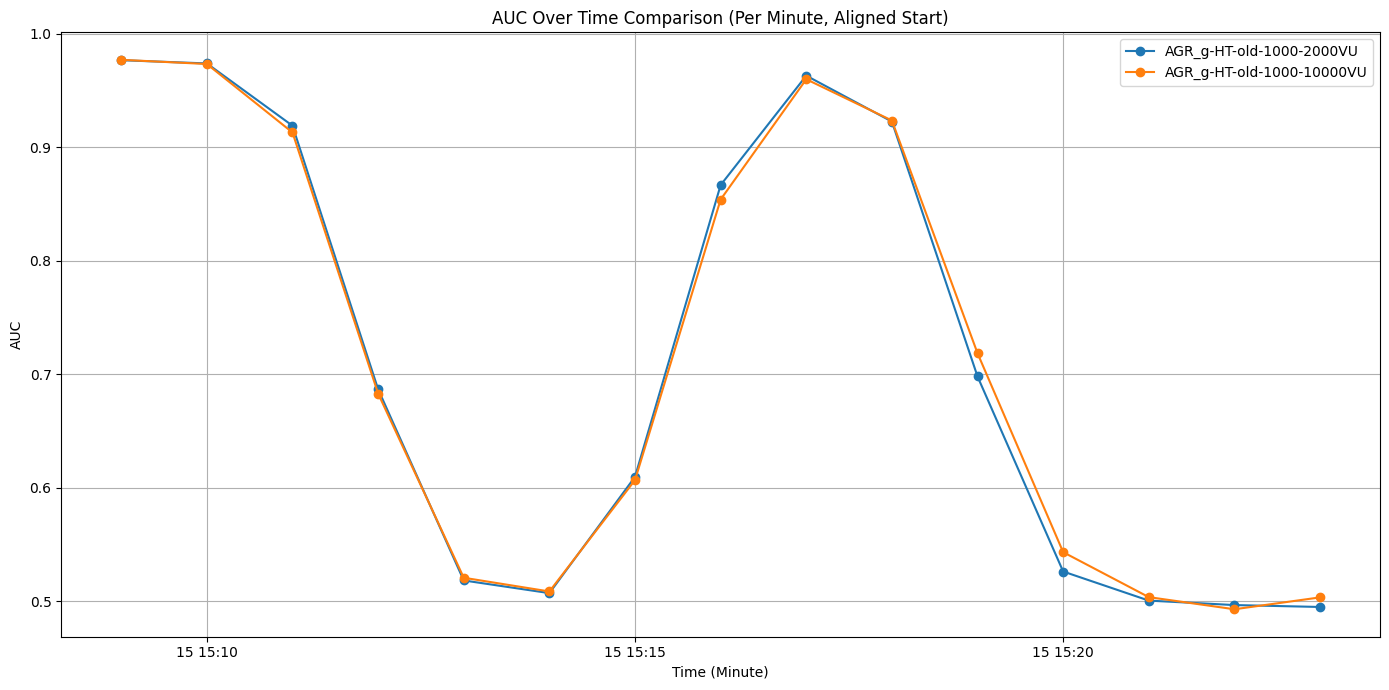

In [5]:
from sklearn.metrics import roc_auc_score

# Measure the auc and make a graph out of it
import matplotlib.pyplot as plt

# Calculate overall AUC
for load_test_results_df in for_auc_df_list:
    auc = roc_auc_score(load_test_results_df["ground_truth"], load_test_results_df["predicted"])
    print(f"Overall AUC: {auc:.4f}")

# Find the global minimum timestamp to align all experiments
min_timestamp = min(pd.to_datetime(df['timestamp']).min() for df in for_auc_df_list)

# Plot AUC per minute for each experiment on one graph for comparison, aligned to the same start time
plt.figure(figsize=(14, 7))
for load_test_results_df in for_auc_df_list:
    df = load_test_results_df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # Shift all timestamps so the minimum is the same for all
    df['timestamp'] = df['timestamp'] - df['timestamp'].min() + min_timestamp
    df.set_index('timestamp', inplace=True)
    auc_per_minute = (
        df.groupby(pd.Grouper(freq='1Min'))
        .apply(lambda x: roc_auc_score(x["ground_truth"], x["predicted"]) if len(x["ground_truth"].unique()) > 1 else None)
    )
    plt.plot(auc_per_minute.index, auc_per_minute.values, marker='o', label=df['experiment'].iloc[0])

plt.title('AUC Over Time Comparison (Per Minute, Aligned Start)')
plt.xlabel('Time (Minute)')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
experiment_name = ["AGR_g-HT-old-1000-2000VU", "AGR_g-HT-old-1000-10000VU"]
for experiment in experiment_name:
    path = f"C:\\Users\\muhammad.aulia\\large-scale-online-learning\\MLOps-Architecture\\Serialization_Datasets\\experiment-results\\{experiment}\\load-test-results"
    filename = "result_testing_stats_history.csv"
    load_test_results_df = pd.read_csv(os.path.join(path, filename))

    # the first column is the timestamp, count how long the experiment going
    column_name = "Timestamp"
    # print(load_test_results_df[column_name].max())
    # print(load_test_results_df[column_name].min())
    # Convert the integer timestamp to datetime before calculating duration
    timestamps = pd.to_datetime(load_test_results_df[column_name], unit='s')
    duration = (timestamps.max() - timestamps.min()).total_seconds() / 60
    print(f"Duration: {duration:.2f} minutes")
    print(f"Experiment name: {experiment}")


Duration: 17.90 minutes
Experiment name: AGR_g-HT-old-1000-2000VU
Duration: 14.37 minutes
Experiment name: AGR_g-HT-old-1000-10000VU


In [ ]:
## Do the same for for_auc_df_list to measure how long the experiment has going
column_name = "timestamp"
for for_auc_df in for_auc_df_list:
    for_auc_df[column_name] = pd.to_datetime(for_auc_df[column_name])
    duration = (for_auc_df[column_name].max() - for_auc_df[column_name].min()).total_seconds() / 60
    print(f"Duration: {duration:.2f} minutes")
    print(f"Experiment name: {for_auc_df['experiment'].iloc[0]}")


In [65]:
# for for_auc_df in for_auc_df_list:
#     num_rows_for_auc_df = len(for_auc_df)
#     print(f"Number of rows in for_auc_df: {num_rows_for_auc_df}")
print(len(for_auc_df_list[0]) + 35)
print(len(for_auc_df_list[1]) + 3901)

495000
494917


In [7]:
# Calculate and plot cumulative AUC for each row in for_auc_df_list
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for df in for_auc_df_list:
    aucs = []
    for i in range(1, len(df)+1):
        # Only calculate AUC if there are at least two unique ground_truth values
        if len(set(df['ground_truth'][:i])) > 1:
            auc = roc_auc_score(df['ground_truth'][:i], df['predicted'][:i])
            aucs.append(auc)
        else:
            aucs.append(None)
    plt.plot(range(1, len(df)+1), aucs, label=df['experiment'].iloc[0])

plt.title('Cumulative AUC per Row')
plt.xlabel('Row Index')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

<Figure size 1400x700 with 0 Axes>

In [1]:
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time

import glob
import os
import tarfile

experiment_name = ["AGR_g-HT-old-1000-2000VU", "AGR_g-HT-old-1000-10000VU"]
for experiment in experiment_name:
    update_results_directory = f"C:\\Users\\muhammad.aulia\\large-scale-online-learning\\MLOps-Architecture\\Serialization_Datasets\\experiment-results\\{experiment}\\update-results"

    # Get every tar.gz file from update_results_directory
    update_results_files = glob.glob(os.path.join(update_results_directory, "*.tar.gz"))

    for tar_path in update_results_files:
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=update_results_directory)


import pandas as pd

for_auc_df_list = []
for experiment in experiment_name:
    update_results_directory = f"C:\\Users\\muhammad.aulia\\large-scale-online-learning\\MLOps-Architecture\\Serialization_Datasets\\experiment-results\\{experiment}\\update-results"
    for_auc_csv_path = os.path.join(update_results_directory + "\\app", "for_auc.csv")
    load_test_results_df = pd.read_csv(for_auc_csv_path, header=None)
    # There is no header in for_auc_csv and the column is like timestamp, ground_truth, and predicted result
    load_test_results_df.columns = ["timestamp", "ground_truth", "predicted"] 
    load_test_results_df['timestamp'] = pd.to_datetime(load_test_results_df['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Jakarta').dt.strftime('%Y-%m-%d %H:%M:%S')
    load_test_results_df['experiment'] = experiment
    for_auc_df_list.append(load_test_results_df)

# Remove rows from for_auc_df_list[1] where the timestamp also exists in for_auc_df_list[0]
timestamps_0 = set(for_auc_df_list[0]['timestamp'])
for_auc_df_list[1] = for_auc_df_list[1][~for_auc_df_list[1]['timestamp'].isin(timestamps_0)]

plt.figure(figsize=(14, 7))
for df in for_auc_df_list:
    grafico = []
    metrica = []
    t_ini = time.time()
    for idx, row in df.iterrows():
        yi = row['ground_truth']
        y_pred = row['predicted']
        metrica.append([yi, y_pred])
        if len(metrica) % 1000 == 0:
            y_true = np.array([i[0] for i in metrica[-1000:]])
            y_score = np.array([i[1] for i in metrica[-1000:]])
            if len(np.unique(y_true)) > 1:
                auc = round(roc_auc_score(y_true, y_score), 4)
                grafico.append(auc)
            else:
                grafico.append(None)
    t_fim = time.time()
    tempo = round(t_fim - t_ini, 4)
    plt.plot(np.arange(1, len(grafico)+1)*1000, grafico, label=f"{df['experiment'].iloc[0]} (time: {tempo}s)")

plt.title('AUC Every 1000 Rows (Online Learning Style)')
plt.xlabel('Row Index')
plt.ylabel('AUC (last 1000)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'for_auc_df_list' is not defined

<Figure size 1400x700 with 0 Axes>

Searching for archives in: C:\Users\muhammad.aulia\large-scale-online-learning\MLOps-Architecture\Serialization_Datasets\experiment-results\AGR_g-HT-old-1000-10000VU\update-results
Extracting: for_auc.tar.gz...
Extracting: message_log.tar.gz...


C:\Users\muhammad.aulia\AppData\Local\Temp\ipykernel_14824\3389803387.py:51: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=experiment_directory)


Extracting: model_upload_latency.tar.gz...
Calculating AUC for AGR_g-HT-old-1000-10000VU...
 -> Calculation finished in 0.5852 seconds.
Calculating AUC for Ideal AGR G...
 -> Calculation finished in 0.6685 seconds.


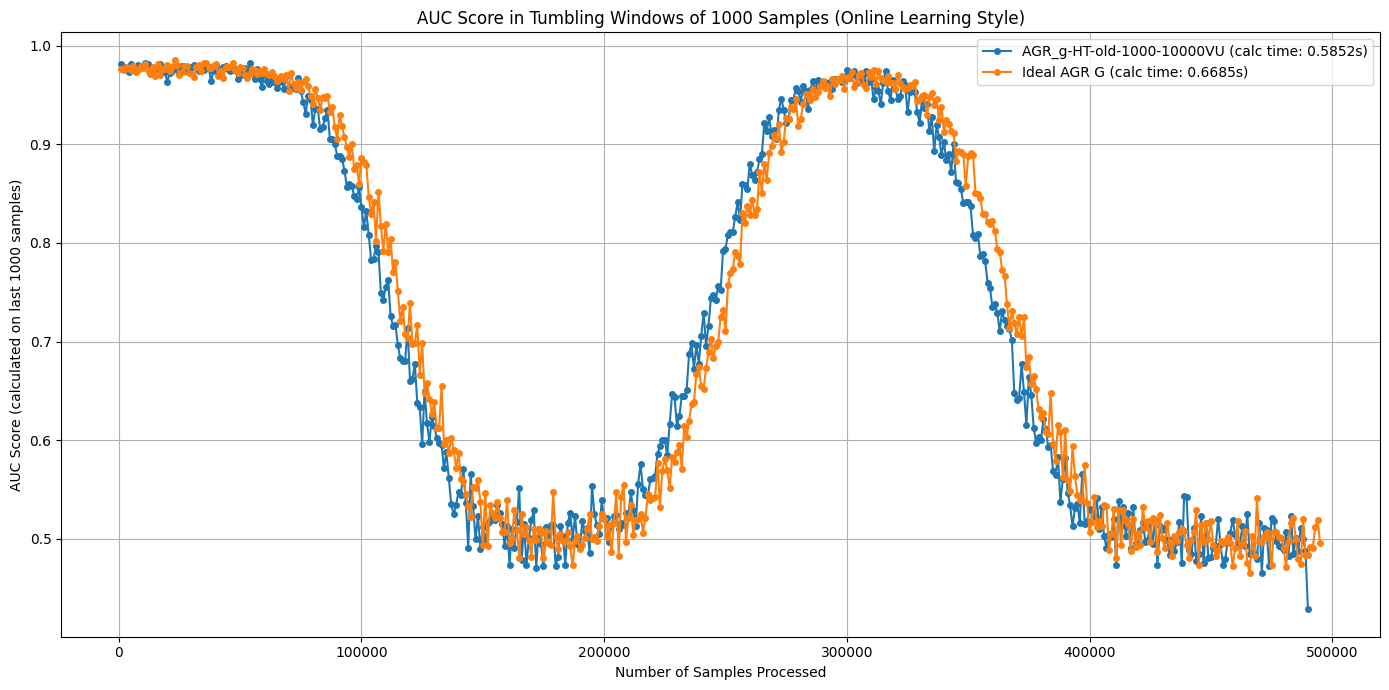

In [4]:
import os
import glob
import tarfile
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# --- Configuration ---
# Define the base directory where experiment results are stored.
# Using os.path.join ensures compatibility across different operating systems.
BASE_RESULTS_PATH = os.path.join("C:", os.sep, "Users", "muhammad.aulia", "large-scale-online-learning", "MLOps-Architecture", "Serialization_Datasets", "experiment-results")

# List of experiment names to process.
EXPERIMENT_NAMES = [
                    "AGR_g-HT-old-1000-10000VU", 
                    # "AGR_g-HT-old-1000-1000VU",
                    # "AGR_g-HT-old-1000-100000VU",
                    # "AGR_g-HT-old-1000-30000VU",
                    # "AGR_a-HT-old-1000-1000VU",
                    # "AGR_a-HT-old-1000-10000VU"
                    ]
WINDOW_SIZE = 1000

def extract_tar_archives(experiment_directory: str):
    """
    Finds and extracts all .tar.gz files in the specified directory.

    Args:
        experiment_directory (str): The path to the directory containing tar.gz files.
    """
    print(f"Searching for archives in: {experiment_directory}")
    # Find all files ending with .tar.gz
    archive_files = glob.glob(os.path.join(experiment_directory, "*.tar.gz"))
    
    if not archive_files:
        print("No .tar.gz archives found.")
        return

    for archive_path in archive_files:
        # Check if the output directory contains the extracted files (skip if exists)
        output_file = os.path.splitext(os.path.splitext(archive_path)[0])[0]  # Remove .tar.gz
        # If the output directory or a known file inside it exists, skip extraction
        if os.path.exists(output_file):
            print(f"Skipping extraction for {os.path.basename(archive_path)} (already extracted).")
            continue
        print(f"Extracting: {os.path.basename(archive_path)}...")
        try:
            with tarfile.open(archive_path, "r:gz") as tar:
                tar.extractall(path=experiment_directory)
        except tarfile.ReadError as e:
            print(f"Error reading archive {archive_path}: {e}")
        except Exception as e:
            print(f"An unexpected error occurred during extraction: {e}")

def load_and_preprocess_results(experiment_name: str, base_path: str) -> pd.DataFrame:
    """
    Loads and preprocesses the 'for_auc.csv' file for a given experiment.

    Args:
        experiment_name (str): The name of the experiment.
        base_path (str): The base directory for all experiments.

    Returns:
        pd.DataFrame: A preprocessed DataFrame with results.
    """
    # Construct the path to the specific CSV file
    csv_path = os.path.join(base_path, experiment_name, "update-results", "app", "for_auc.csv")
    
    if not os.path.exists(csv_path):
        print(f"Warning: CSV file not found at {csv_path}")
        return pd.DataFrame() # Return an empty DataFrame if file doesn't exist

    # Load the data, assuming no header
    results_df = pd.read_csv(csv_path, header=None)
    
    # Assign clear column names
    results_df.columns = ["timestamp", "ground_truth", "prediction"]
    
    # Convert UNIX timestamp to a readable, localized datetime string
    results_df['timestamp'] = pd.to_datetime(results_df['timestamp'], unit='s') \
                                .dt.tz_localize('UTC') \
                                .dt.tz_convert('Asia/Jakarta') \
                                .dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # Tag the data with the experiment name for easy identification
    results_df['experiment'] = experiment_name
    
    return results_df

def calculate_tumbling_window_auc(results_df: pd.DataFrame, window_size: int) -> list:
    """
    Calculates AUC over non-overlapping ("tumbling") windows of a specified size.
    This is much more efficient than iterating row by row.

    Args:
        results_df (pd.DataFrame): DataFrame with 'ground_truth' and 'prediction'.
        window_size (int): The number of rows in each window to calculate AUC.

    Returns:
        list: A list of AUC scores for each window.
    """
    if results_df.empty:
        return []

    # Create a grouper array that assigns each row to a window
    grouper = np.arange(len(results_df)) // window_size

    def auc_for_group(group):
        """Helper function to safely calculate AUC for a single group."""
        # AUC is only defined if there are both positive and negative samples
        if len(group['ground_truth'].unique()) > 1:
            return roc_auc_score(group['ground_truth'], group['prediction'])
        else:
            # Return NaN (Not a Number) if AUC is undefined for the window
            return np.nan

    # Group the DataFrame by the window index and apply the AUC calculation
    auc_scores = results_df.groupby(grouper).apply(auc_for_group)
    
    return auc_scores.tolist()


"""
Main function to orchestrate the data processing and plotting workflow.
"""
all_results_dfs = []

# --- 1. Extract and Load Data for Each Experiment ---
for name in EXPERIMENT_NAMES:
    update_dir = os.path.join(BASE_RESULTS_PATH, name, "update-results")
    extract_tar_archives(update_dir)
    df = load_and_preprocess_results(name, BASE_RESULTS_PATH)
    if not df.empty:
        all_results_dfs.append(df)


# Read df C:\Users\muhammad.aulia\large-scale-online-learning\MLOps-Architecture\Serialization_Datasets\experiment-results\AGR_g_hoeffding_results.csv
agr_g_real_df = pd.read_csv("C:\\Users\\muhammad.aulia\\large-scale-online-learning\\MLOps-Architecture\\Serialization_Datasets\\experiment-results\\AGR_g_hoeffding_results.csv")
# add column new and add to all row, which 'experiment' column with value 'Ideal AGR G'
agr_g_real_df['experiment'] = 'Ideal AGR G'
all_results_dfs.append(agr_g_real_df)

if len(all_results_dfs) < 2:
    print("Not enough data to perform comparison. Exiting.")

# --- 3. Calculate AUC and Plot Results ---
plt.figure(figsize=(14, 7))

for df in all_results_dfs:
    experiment_label = df['experiment'].iloc[0]
    print(f"Calculating AUC for {experiment_label}...")

    start_time = time.time()
    auc_scores = calculate_tumbling_window_auc(df, window_size=WINDOW_SIZE)
    end_time = time.time()
    
    duration = round(end_time - start_time, 4)
    print(f" -> Calculation finished in {duration} seconds.")

    # Generate x-axis values (e.g., 1000, 2000, 3000...)
    row_indices = np.arange(1, len(auc_scores) + 1) * WINDOW_SIZE
    
    # Plot the results
    plt.plot(row_indices, auc_scores, marker='o', linestyle='-', markersize=4, label=f"{experiment_label} (calc time: {duration}s)")

# --- 4. Finalize and Show Plot ---
plt.title(f'AUC Score in Tumbling Windows of {WINDOW_SIZE} Samples (Online Learning Style)')
plt.xlabel('Number of Samples Processed')
plt.ylabel(f'AUC Score (calculated on last {WINDOW_SIZE} samples)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
